# Harvard Elionix Batch Export Script

## ReadMe

In [3]:
# Every part of this code works on LWPOLYINES and LWPOLYLINES ONLY
# If you are doing lithography, you should be using nothing else.
# If you have circles, you should explode them to polylines with fixed resolution, because this is what lithography softwares read... etc.
# All alignment marks are indicated by the bottom left corner of rectangles on the alignment layers
# The matrix layer should outline the extent of each device (a bounding box). This allows the software to find a bottom left corner to be the origin.
# This code can take final dxfs ready for export to EBL and prepare them for writes on one of the two Elionix instruments at Harvard.
#     Export modes can be without global alignment (simple unaligned write, good for the first EBL layer), with global alignment, or with local and global alignment.
#            Note that only 4 point alignment is available at this time. If you are going to do alignment, might as well.
#     All layers in "active layers" list will be written

# While this code was built to deal with matrixed device writing for semiconductor fab with local and global alignment, it can also be used for simple 1-off CAD files.
# Simply set num_cols=num_rows=1 and make sure your device is surrounded by a bounding box called matrix.
# This code can be easily modified to toggle other parameters in this simple flow, or to accomadate other "standard" flows for whatever the user deems to be standard.
# See the BEAMER docs for how to export a flow to python gobj in order to integrate into this notebook (almost as easy as drag and drop, just need to worry about variable renaming).
# To implment not on the Harvard BEAMER computer, you will need to change the paths for the BEAMER exe, lib, and psf lib. 
# See the companion DXFPreprocessing Script to generate matrixed device chips
# This code plots the nearest version of the input DXF used as an input to the BEAMER flow. However, checking the EBL file output file is read by the EBL software is always reccomended

# PLEASE REPORT BUGS to aksaydjari@gmail.com (suggestiions/code contributions are also appreciated)

### Import

In [4]:
import os
import sys
import datetime
import ezdxf
import numpy as np
import string
from itertools import chain
from scipy.spatial import ConvexHull
from itertools import repeat
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, LineString
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('dark_background')

sys.path.append("C:/Program Files/BEAMER/v5.9.1_x64")
sys.path.append("C:/Program Files/BEAMER/lib.0_x64")
import BEAMERpy
BEAMER = BEAMERpy.GBEAMER()
BEAMER.set_psf_archive_folder({ 'ArchivePath' : 'C:/Users/Public/Documents/.GenISys/TRACER/2D.Archive'})

### User Area

In [5]:
# File Parameters
inputFileName = "QC0567p7_exportTest.dxf"
align_global_layer = "align_global_1"
align_local_layer = "align_local_1"
align_markers_layer = "align_marks"
matrix_layer = "matrix"
active_layers = ["TG"]

fabStepName = 'TG'

# Beamer Parameters
field = 500 # um
dots = 50000
current = 48 # nA
resistEBL = 'A4'
sampleName = 'QC0567p7'
baseDose = 2000 #uC/cm^2
dosefactor = 0.75
EBLprinter = 5 #5 or 6

# 1 == yes; 0 == no
local_align_on  = 1
global_align_on  = 1
ref_align_con_on = 0
pec_on = 0
psf_string = 'Substrate_GaAs_Thickness_700000_Energy_125_Layers_PMMA 216 nm_Resist_HSQ 40 nm_Z-Position_0.1856_Electrons_1000000_Alpha_0_Beta_0_Eta_0_Gamma1_0_Nue1_0_Gamma2_0_Nue2_0_Simulator_mcTrace 1.1.0'
field_option = 'Floating' #'Floating' or 'Fixed'

## Temp Matrix Parameters
device_size_x = 860
device_size_y = 860
device_width_x = 860
device_width_y = 860
num_rows = 3                            #max is 9, if you are writing more than 81 devices per chip, go to industry,  
num_cols = 3                            #collect more than $200 and send it to aksaydjari@gmail.com

### Helper Functions

In [11]:
baseExportName = fabStepName + '_' + str(current) + 'nA' + '_' + resistEBL + '_' + sampleName + '.con'
globalExportName = 'global'+ '_' + fabStepName + '_' + sampleName + '.con'
baseDoseTime = (baseDose/current)*(field/dots)**2*10**(1) #us

In [12]:
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)
def grabAlignPoints(msp, align_layer):
    align_points =[]
    lines = msp.query('LWPOLYLINE[layer=="{}"]'.format(align_layer))
    for idx, e in enumerate(lines):
        polyLineVertices = []
        for j, ver in enumerate(e.vertices()):
            polyLineVertices.append(tuple(list((ver[0],ver[1]))))
        align_points.append(OrderPointsABCDElionix(polyLineVertices)[0])
    return align_points
def OrderPointsABCDElionix(pointList):
    ordering_list = np.rad2deg(list(map(np.arctan2, 
                        [x[0] for x in pointList]-np.mean(pointList,axis=0)[0],
                        [x[1] for x in pointList]-np.mean(pointList,axis=0)[1])))
    
    sorted_pts = [x for _,x in sorted(zip(ordering_list,[x[0:2] for x in pointList]))]
    switched_pts = [sorted_pts[0],sorted_pts[3],sorted_pts[1],sorted_pts[2]]
    return switched_pts
def assignMatrixIndex(filename,matrix_indices,active_layers,align_local_layer):
    df = importDXFtoGPDwPolygons(filename)

    boolOut = gpd.GeoDataFrame([])
    for idny, n in enumerate(matrix_indices):
        for idnx, x in enumerate(active_layers):
            temp = gpd.GeoDataFrame([])
            temp = relabelPostBool(boolAnd(df,'mask_{}'.format(n),x))
            boolOut = boolOut.append(temp, ignore_index=True)
    boolOut = boolOut.append(df[df['Layer'] == align_local_layer])
    return boolOut
def importDXFtoGPDwPolygons(fileName):
    df = gpd.read_file(fileName)
    df1 = df[df['SubClasses'] == 'AcDbEntity:AcDbPolyline']
    df2 = df1.copy()
    df2['geometry'] = df1['geometry'].apply(lambda x: Polygon(x.coords))
    return df2
def exportGPDwPolygonstoDXF(df):
    df1 = df.copy()
    df1['geometry'] = df['geometry'].apply(lambda x: LineString(x.exterior.coords))
    return df1
def relabelPostBool(df):
    sep = '_'
    df['Layer'] = df.apply(lambda x: sep.join((x.Layer_2,x.Layer_1.split('_')[-1])), axis=1)
    cols = df.columns.tolist() 
    cols = cols[-1:] + cols[7:-2] + cols[-2:-1]
    df1 = df[cols]
    return df1.rename(columns = {x: x.split('_')[0] for x in cols[1:-1]})
def boolAnd(df,layer1,layer2):
    dfa = df[df['Layer'] == layer1]
    dfb = df[df['Layer'] == layer2]
    return gpd.GeoDataFrame(gpd.overlay(dfa, dfb, how='intersection'))
def resaveWLayerColor(fileName, layerDict):
    doc = ezdxf.readfile(fileName)
    modelspace = doc.modelspace()
    for layer in doc.layers:
        splitName = layer.dxf.name.split('_')
        if len(splitName)>1 and splitName[-1].isnumeric():
            if splitName[-1] in matrix_indices:
                layer.color = layerDict[layer.dxf.name.split('_')[0]]
            else:
                layer.color = layerDict[layer.dxf.name]
        else:
            layer.color = layerDict[layer.dxf.name]
    for e in modelspace.query('LWPOLYLINE'):
        e.dxf.flags = 1
    doc.saveas('{}_c.dxf'.format(os.path.splitext(fileName)[0]))
def getLayerDic(doc):
    layers = doc.layers
    return {lay.dxf.name: lay.color for lay in layers}

In [13]:
doc = ezdxf.readfile(inputFileName)
modelspace = doc.modelspace()
for e in modelspace.query('LWPOLYLINE'):
    if e.closed == 0:
        print('You have open polylines. Go use linkCAD')

### SCON Single Field No Alignment

In [14]:
if global_align_on == 0:
    
    #Plot the final dxf file which was written to EBL
    df = gpd.read_file(inputFileName)
    ax = df.plot(column='Layer', figsize=(20,30), cmap='Dark2')
    ax.set_facecolor((0, 0, 0))
    
    fieldDoseTotal = {}
    fieldDoseMin = {}

    dose_list = []
    for x in active_layers:
        dose_list.append([x,dosefactor])

    layer_set = ''
    for x in active_layers:
        if active_layers.index(x) == 0:
            layer_set = layer_set + x
        else:
            layer_set = layer_set + ',' + x

    fileExportName = baseExportName

    gobj_11 = BEAMER.import_dxf( {
        'LayerSet' : '*',
        'DXFUnits' : 'um',
        'DXFPolyMode' : 'ConvertToPolygon',
        'MaxErrorForConversion' : 0.001000,
        'SnappingRange' : 0.000500,
        'DXFDatabaseGrid' : 0.001000,
        'UseDXFInternalPrecision' : True,
        'ConvertDXFColorToDatatype' : False,
        'LoadTextElements' : False,
        'ConvertTextElementsToPolys' : False,
        'PreserveSingleLines' : False,
        'KeepElementOrder' : False,
        'ConvertedTextSize' : 1.000000,
        'PreserveSingleLines' : False,
        'FileName' : inputFileName } )
    
    gobj_21 = BEAMER.extract( gobj_11, {
        'ExtentMode' : 'Default',
        'ExtractMode' : 'EntireLayoutExtract',
        'CellName' : '',
        'LayerSet' : layer_set,
        'RegionLayer' : '',
        'RegionLayerBehavior' : 'Clip',
        'AllExceptForRegions' : False,
        'DoseClassificationShrink' : 0,
        'KeepRegionLayer' : False,
        'ExtractBoxes' : [] } )

    fieldDoseTotal = BEAMER.get_area(gobj_21)*baseDoseTime*(dots/field)**2*10**(-6)*dosefactor

    gobj_31 = BEAMER.heal( gobj_21, {
        'TargetLayer' : '1(0)',
        'SoftFrame' : 0.300000,
        'HierarchicalProcessing' : True,
        'SelectedLayerSet' : layer_set,
        'LayerAssignment' : 'PerLayer',
        'ProcessingMode' : 'Healing' } )

    if pec_on == 1:
        gobj_41 = BEAMER.pec( gobj_31, {
            'UserdefinedDoseClassFile' : '**filename**', 
            'MinFractureSizeMode' : 'Automatic', 
            'BeamSize' : 0.010000, 
            'DoseClassMode' : 'Accuracy', 
            'MaxNumOfDoseClasses' : 256, 
            'Accuracy' : 1.000000, 
            'UserDefinedSeparationValue' : False, 
            'SeparationValue' : 0.100000, 
            'FractureGrid' : 0.010000, 
            'MinFractureSize' : 0.100000, 
            'MinFractureSizeShortRange' : 0.100000, 
            'MinDoseFactor' : 0.100000, 
            'MaxDoseFactor' : 10.000000, 
            'LayerListForCorrection' : '*', 
            'LayerListForFullCorrection' : layer_set, 
            'LayerForFracture' : '*', 
            'ContrastPartofLRPEC' : 100.000000, 
            'PSFFileName' : '', 
            'OverdoseFactor' : 1.000000, 
            'PSFType' : 'Archive', 
            'MidRangeActivationThreshold' : 2.000000, 
            'SingleLineBeamWidth' : 0.000000, 
            'IncludeSRCorrection' : False, 
            'HierarchicShortRangePEC' : True, 
            'HierarchicLongRangePEC' : False, 
            'ConvergenceOutput' : False, 
            'IncludeLateralDevelopment' : False, 
            'LateralDevelopmentGrid' : 0.100000, 
            'PSFArchiveIdentifierString' : psf_string, 
            'CellsToKeep' : '', 
            'Use2dLateralDevelopmentBias' : False } )
    else:
        gobj_41 = gobj_31
            
    gobj_51 = BEAMER.fda( gobj_41, {
        'AssignmentType' : 'Multiply',
        'AssignmentMode' : 'ByLayer',
        'LayerDoseList' : dose_list,
        'LayerDoseSigmaList' : [] } )

    fieldDoseMin = BEAMER.get_min_dose(gobj_41)*baseDoseTime*dosefactor
    
    if EBLprinter == 5:
        gobj_61 = BEAMER.export_con( gobj_51, { 
             'FileName' : fileExportName, 
             'ExtentMode' : 'Default', 
             'LowerLeftX' : 0.000000, 
             'LowerLeftY' : 0.000000, 
             'UpperRightX' : 0.000000, 
             'UpperRightY' : 0.000000, 
             'FormatType' : 'SCON', 
             'FieldSizeX' : format(field, '.5f'), 
             'FieldSizeY' : format(field, '.5f'), 
             'DotNumber' : dots, 
             'MaximumFieldSize' : field, 
             'BaseDoseTime' : format(baseDoseTime, '.5f'), 
             'RectangleOrientation' : 'X_AND_Y', 
             'PitchSize' : 1, 
             'NumberGlobalMarks' : 0, 
             'MarkA_X' : 0.000000, 'MarkA_Y' : 0.000000, 
             'MarkB_X' : 0.000000, 'MarkB_Y' : 0.000000, 
             'MarkC_X' : 0.000000, 'MarkC_Y' : 0.000000, 
             'MarkD_X' : 0.000000, 'MarkD_Y' : 0.000000, 
             'LocalMarkCommand' : 'None', 
             'LocalMarkPositionX1' : 0.000000, 'LocalMarkPositionY1' : 0.000000, 
             'LocalMarkPositionX2' : 0.000000, 'LocalMarkPositionY2' : 0.000000, 
             'LocalMarkPositionX3' : 0.000000, 'LocalMarkPositionY3' : 0.000000, 
             'LocalMarkPositionX4' : 0.000000, 'LocalMarkPositionY4' : 0.000000, 
             'RegionLayer' : '', 
             'FieldTraversalType' : field_option, 
             'FixedFieldTraversal' : 'MeanderX', 
             'FractureMode' : 'Curved', 
             'CurveTolerance' : 1.000000, 
             'ShotPitchAlignment' : 'NONE', 
             'DoseTimeInterpolation' : False, 
             'ReplaceFiles' : False, 
             'GenerateFolder' : False, 
             'GenerateCCCFiles' : True, 
             'GenerateCPGData' : True, 
             'GenerateParallelograms' : False, 
             'KeepLayoutPosition' : True, 
             'CenterFieldFrames' : False, 
             'AdaptDoseToShotPitch' : 'CONSTANT', 
             'AreaSelection' : 'SelectedThenRemainder', 
             'FeatureOrderingType' : 'NoCompaction', 
             'CompRegSize' : 500, 
             'RegTraversal' : 'MeanderX', 
             'SortedOrderLayer' : '*', 
             'DoseMapping' : 'DoseToTime', 
             'FieldOverlapX' : 0.000000, 
             'FieldOverlapY' : 0.000000, 
             'OverlapMethod' : 'Share between Fields', 
             'InterleavingSize' : 0.000000, 
             'InterlockLayer' : '*', 
             'MultipassMode' : 'Single Pass', 
             'MultipassFieldArrangement' : 'Shortest Path', 
             'MainfieldOffsetX' : 0.500000, 
             'MainfieldOffsetY' : 0.500000, 
             'SubfieldOffsetX' : 0.000000, 
             'SubfieldOffsetY' : 0.000000, 
             'MultipassLayer' : '*', 
             'UserDosePass' : []} )
    elif EBLprinter == 6:
        gobj_61 = BEAMER.export_car( gobj_51, { 
            'FileName' : fileExportName.split('.')[0] + '.car', 
            'ExtentMode' : 'Minimum', 
            'LowerLeftX' : 0.000000, 
            'LowerLeftY' : 0.000000, 
            'UpperRightX' : 0.000000, 
            'UpperRightY' : 0.000000, 
            'ReplaceFiles' : False, 
            'GenerateFolder' : True, 
            'FormatType' : 'Fixed subfield', 
            'MaximumFieldSize' : field, 
            'SubfieldSize' : 10.0, 
            'FieldSizeX' : format(field, '.5f'), 
            'FieldSizeY' : format(field, '.5f'),
            'PitchSize' : 1, 
            'AdaptDoseToShotPitch' : 'CONSTANT', 
            'RectangleOrientation' : 'X_AND_Y', 
            'GenerateCPGData' : True, 
            'GenerateParallelograms' : False, 
            'FieldTraversalType' : field_option, 
            'KeepLayoutPosition' : True, 
            'FractureMode' : 'Curved', 
            'CurveTolerance' : 1.000000, 
            'SymmetricFracturing' : False, 
            'ShotPitchAlignment' : 'NONE', 
            'FeatureOrderingType' : 'FixedSubfields', 
            'SortedOrderLayer' : '*', 
            'CompRegSize' : field, 
            'RegTraversal' : 'MeanderX', 
            'FixedSubfieldOrigin' : 'CenterToCenter', 
            'LocalMarkCommand' : 'None', 
            'LocalMarkPositionX1' : 0.000000, 
            'LocalMarkPositionY1' : 0.000000, 
            'LocalMarkPositionX2' : 0.000000, 
            'LocalMarkPositionY2' : 0.000000, 
            'LocalMarkPositionX3' : 0.000000, 
            'LocalMarkPositionY3' : 0.000000, 
            'LocalMarkPositionX4' : 0.000000, 
            'LocalMarkPositionY4' : 0.000000, 
            'FieldAlignmentCommand' : 'None', 
            'FieldMarkPosition1X' : 0.000000, 
            'FieldMarkPositionY' : 0.000000, 
            'FieldMarkPosition2X' : 0.000000, 
            'FieldMarkPosition2Y' : 0.000000, 
            'FinePitch_X' : '', 
            'FinePitch_Y' : '', 
            'Moving_Z' : '', 
            'MovingXY_X' : '', 
            'MovingXY_Y' : '', 
            'FieldOverlapX' : 0.000000, 
            'FieldOverlapY' : 0.000000, 
            'MultipassMode' : 'Single Pass' } )
    else:
            print("That EBL instrument is not yet implemented")

### SCON Global Alignment Marks Only

In [15]:
global_pts_list = grabAlignPoints(modelspace,align_global_layer)

if np.logical_and(len(global_pts_list)==4,global_align_on):
    swtiched_global_pts = OrderPointsABCDElionix(global_pts_list)
    final_global_pts = [tuple(map(lambda y: y*10**(-3),x)) for x in swtiched_global_pts]
    
    layer_set = ''
    for x in active_layers:
        if active_layers.index(x) == 0:
            layer_set = layer_set + x
        else:
            layer_set = layer_set + ',' + x
    
    gobj_1 = BEAMER.import_dxf( {
    'LayerSet' : '*',
    'DXFUnits' : 'um',
    'DXFPolyMode' : 'ConvertToPolygon',
    'MaxErrorForConversion' : 0.001000,
    'SnappingRange' : 0.000500,
    'DXFDatabaseGrid' : 0.001000,
    'UseDXFInternalPrecision' : True,
    'ConvertDXFColorToDatatype' : False,
    'LoadTextElements' : False,
    'ConvertTextElementsToPolys' : False,
    'PreserveSingleLines' : False,
    'KeepElementOrder' : False,
    'ConvertedTextSize' : 1.000000,
    'PreserveSingleLines' : False,
    'FileName' : inputFileName } )
    
    gobj_2 = BEAMER.extract( gobj_1, {
    'ExtentMode' : 'Default',
    'ExtractMode' : 'EntireLayoutExtract',
    'CellName' : '',
    'LayerSet' : layer_set,
    'RegionLayer' : '',
    'RegionLayerBehavior' : 'Clip',
    'AllExceptForRegions' : False,
    'DoseClassificationShrink' : 0,
    'KeepRegionLayer' : False,
    'ExtractBoxes' : [] } )
    
    gobj_3 = BEAMER.filter( gobj_2, { 'SelectionList' : [{
        'GlobalMode' : 'AND',
        'TargetLayer' : 'KeepLayer',
        'TargetLayerName' : '',
        'RuleList' : [{'Attribute' : 'RelativeDose', 'Criteria1' : '>', 'Value1' : '200'}]}] } )
    
    if EBLprinter == 5:
        gobj_4 = BEAMER.export_con( gobj_3, {
            'FileName' : globalExportName,
            'ExtentMode' : 'Default',
            'LowerLeftX' : 0.000000,
            'LowerLeftY' : 0.000000,
            'UpperRightX' : 0.000000,
            'UpperRightY' : 0.000000,
            'FormatType' : 'SCON',
            'FieldSizeX' : format(field, '.5f'), 
            'FieldSizeY' : format(field, '.5f'), 
            'DotNumber' : dots, 
            'MaximumFieldSize' : field, 
            'BaseDoseTime' : format(baseDoseTime, '.5f'), 
            'RectangleOrientation' : 'X_AND_Y', 
            'PitchSize' : 1, 
            'NumberGlobalMarks' : 4,
            'MarkA_X' : format(final_global_pts[0][0], '.5f'), 'MarkA_Y' : format(final_global_pts[0][1], '.5f'),
            'MarkB_X' : format(final_global_pts[1][0], '.5f'), 'MarkB_Y' : format(final_global_pts[1][1], '.5f'),
            'MarkC_X' : format(final_global_pts[2][0], '.5f'), 'MarkC_Y' : format(final_global_pts[2][1], '.5f'),
            'MarkD_X' : format(final_global_pts[3][0], '.5f'), 'MarkD_Y' : format(final_global_pts[3][1], '.5f'),
            'LocalMarkCommand' : 'None',
            'LocalMarkPositionX1' : 0.000000, 'LocalMarkPositionY1' : 0.000000,
            'LocalMarkPositionX2' : 0.000000, 'LocalMarkPositionY2' : 0.000000,
            'LocalMarkPositionX3' : 0.000000, 'LocalMarkPositionY3' : 0.000000,
            'LocalMarkPositionX4' : 0.000000, 'LocalMarkPositionY4' : 0.000000,
            'RegionLayer' : '',
            'FieldTraversalType' : 'Fixed',
            'FixedFieldTraversal' : 'MeanderX',
            'FractureMode' : 'Curved',
            'CurveTolerance' : 1.000000,
            'ShotPitchAlignment' : 'NONE',
            'DoseTimeInterpolation' : False,
            'ReplaceFiles' : False,
            'GenerateFolder' : False,
            'GenerateCCCFiles' : True,
            'GenerateCPGData' : True,
            'GenerateParallelograms' : False,
            'KeepLayoutPosition' : True,
            'CenterFieldFrames' : False,
            'AdaptDoseToShotPitch' : 'CONSTANT',
            'AreaSelection' : 'SelectedThenRemainder',
            'FeatureOrderingType' : 'NoCompaction',
            'CompRegSize' : 500,
            'RegTraversal' : 'MeanderX',
            'SortedOrderLayer' : '*',
            'DoseMapping' : 'DoseToTime',
            'FieldOverlapX' : 0.000000,
            'FieldOverlapY' : 0.000000,
            'OverlapMethod' : 'Share between Fields',
            'InterleavingSize' : 0.000000,
            'InterlockLayer' : '*',
            'MultipassMode' : 'Single Pass',
            'MultipassFieldArrangement' : 'Shortest Path',
            'MainfieldOffsetX' : 0.500000,
            'MainfieldOffsetY' : 0.500000,
            'SubfieldOffsetX' : 0.000000,
            'SubfieldOffsetY' : 0.000000,
            'MultipassLayer' : '*',
            'UserDosePass' : [],
            'RegionList' : [] } )
    elif EBLprinter == 6:
        with open('EL6_alignment.txt','w') as f:
            print('AX {}'.format(final_global_pts[0][0], '.5f'), file=f)
            print('AY {}'.format(final_global_pts[0][1], '.5f'), file=f)

            print('BX {}'.format(final_global_pts[1][0], '.5f'), file=f)
            print('BY {}'.format(final_global_pts[1][1], '.5f'), file=f)

            print('CX {}'.format(final_global_pts[2][0], '.5f'), file=f)
            print('CY {}'.format(final_global_pts[2][1], '.5f'), file=f)

            print('DX {}'.format(final_global_pts[3][0], '.5f'), file=f)
            print('DY {}'.format(final_global_pts[3][1], '.5f'), file=f)
    else:
        print("That EBL instrument is not yet implemented")

### SCON Reference For Alignment Mark Selection Check

In [16]:
if ref_align_con_on == 1:
    
    fileExportName = 'alignRef_{}'.format(baseExportName)
    
    gobj_13 = BEAMER.import_dxf( {
    'LayerSet' : '*',
    'DXFUnits' : 'um',
    'DXFPolyMode' : 'ConvertToPolygon',
    'MaxErrorForConversion' : 0.001000,
    'SnappingRange' : 0.000500,
    'DXFDatabaseGrid' : 0.001000,
    'UseDXFInternalPrecision' : True,
    'ConvertDXFColorToDatatype' : False,
    'LoadTextElements' : False,
    'ConvertTextElementsToPolys' : False,
    'PreserveSingleLines' : False,
    'KeepElementOrder' : False,
    'ConvertedTextSize' : 1.000000,
    'PreserveSingleLines' : False,
    'FileName' : inputFileName } )

    gobj_23 = BEAMER.extract( gobj_13, {
        'ExtentMode' : 'Default',
        'ExtractMode' : 'EntireLayoutExtract',
        'CellName' : '',
        'LayerSet' : align_markers_layer,
        'RegionLayer' : '',
        'RegionLayerBehavior' : 'Clip',
        'AllExceptForRegions' : False,
        'DoseClassificationShrink' : 0,
        'KeepRegionLayer' : False,
        'ExtractBoxes' : [] } )
    if EBLprinter == 5:
        gobj_33 = BEAMER.export_con( gobj_23, {
            'FileName' : fileExportName,
            'ExtentMode' : 'Default',
            'LowerLeftX' : 0.000000,
            'LowerLeftY' : 0.000000,
            'UpperRightX' : 0.000000,
            'UpperRightY' : 0.000000,
            'FormatType' : 'SCON',
            'FieldSizeX' : format(field, '.5f'), 
            'FieldSizeY' : format(field, '.5f'), 
            'DotNumber' : dots, 
            'MaximumFieldSize' : field, 
            'BaseDoseTime' : format(baseDoseTime, '.5f'), 
            'RectangleOrientation' : 'X_AND_Y', 
            'PitchSize' : 1, 
            'NumberGlobalMarks' : 0,
            'MarkA_X' : 0.000000, 'MarkA_Y' : 0.000000, 
            'MarkB_X' : 0.000000, 'MarkB_Y' : 0.000000, 
            'MarkC_X' : 0.000000, 'MarkC_Y' : 0.000000, 
            'MarkD_X' : 0.000000, 'MarkD_Y' : 0.000000, 
            'LocalMarkCommand' : 'None',
            'LocalMarkPositionX1' : 0.000000, 'LocalMarkPositionY1' : 0.000000,
            'LocalMarkPositionX2' : 0.000000, 'LocalMarkPositionY2' : 0.000000,
            'LocalMarkPositionX3' : 0.000000, 'LocalMarkPositionY3' : 0.000000,
            'LocalMarkPositionX4' : 0.000000, 'LocalMarkPositionY4' : 0.000000,
            'RegionLayer' : '',
            'FieldTraversalType' : 'Fixed',
            'FixedFieldTraversal' : 'MeanderX',
            'FractureMode' : 'Curved',
            'CurveTolerance' : 1.000000,
            'ShotPitchAlignment' : 'NONE',
            'DoseTimeInterpolation' : False,
            'ReplaceFiles' : False,
            'GenerateFolder' : False,
            'GenerateCCCFiles' : True,
            'GenerateCPGData' : True,
            'GenerateParallelograms' : False,
            'KeepLayoutPosition' : True,
            'CenterFieldFrames' : False,
            'AdaptDoseToShotPitch' : 'CONSTANT',
            'AreaSelection' : 'SelectedThenRemainder',
            'FeatureOrderingType' : 'NoCompaction',
            'CompRegSize' : 500,
            'RegTraversal' : 'MeanderX',
            'SortedOrderLayer' : '*',
            'DoseMapping' : 'DoseToTime',
            'FieldOverlapX' : 0.000000,
            'FieldOverlapY' : 0.000000,
            'OverlapMethod' : 'Share between Fields',
            'InterleavingSize' : 0.000000,
            'InterlockLayer' : '*',
            'MultipassMode' : 'Single Pass',
            'MultipassFieldArrangement' : 'Shortest Path',
            'MainfieldOffsetX' : 0.500000,
            'MainfieldOffsetY' : 0.500000,
            'SubfieldOffsetX' : 0.000000,
            'SubfieldOffsetY' : 0.000000,
            'MultipassLayer' : '*',
            'UserDosePass' : [],
            'RegionList' : [] } )
    elif EBLprinter == 6:
        gobj_33 = BEAMER.export_car( gobj_23, { 
            'FileName' : fileExportName.split('.')[0] + '.car', 
            'ExtentMode' : 'Minimum', 
            'LowerLeftX' : 0.000000, 
            'LowerLeftY' : 0.000000, 
            'UpperRightX' : 0.000000, 
            'UpperRightY' : 0.000000, 
            'ReplaceFiles' : False, 
            'GenerateFolder' : True, 
            'FormatType' : 'Fixed subfield', 
            'MaximumFieldSize' : field, 
            'SubfieldSize' : 10.0, 
            'FieldSizeX' : format(field, '.5f'), 
            'FieldSizeY' : format(field, '.5f'),
            'PitchSize' : 1, 
            'AdaptDoseToShotPitch' : 'CONSTANT', 
            'RectangleOrientation' : 'X_AND_Y', 
            'GenerateCPGData' : True, 
            'GenerateParallelograms' : False, 
            'FieldTraversalType' : field_option, 
            'KeepLayoutPosition' : True, 
            'FractureMode' : 'Curved', 
            'CurveTolerance' : 1.000000, 
            'SymmetricFracturing' : False, 
            'ShotPitchAlignment' : 'NONE', 
            'FeatureOrderingType' : 'FixedSubfields', 
            'SortedOrderLayer' : '*', 
            'CompRegSize' : field, 
            'RegTraversal' : 'MeanderX', 
            'FixedSubfieldOrigin' : 'CenterToCenter', 
            'LocalMarkCommand' : 'None', 
            'LocalMarkPositionX1' : 0.000000, 
            'LocalMarkPositionY1' : 0.000000, 
            'LocalMarkPositionX2' : 0.000000, 
            'LocalMarkPositionY2' : 0.000000, 
            'LocalMarkPositionX3' : 0.000000, 
            'LocalMarkPositionY3' : 0.000000, 
            'LocalMarkPositionX4' : 0.000000, 
            'LocalMarkPositionY4' : 0.000000, 
            'FieldAlignmentCommand' : 'None', 
            'FieldMarkPosition1X' : 0.000000, 
            'FieldMarkPositionY' : 0.000000, 
            'FieldMarkPosition2X' : 0.000000, 
            'FieldMarkPosition2Y' : 0.000000, 
            'FinePitch_X' : '', 
            'FinePitch_Y' : '', 
            'Moving_Z' : '', 
            'MovingXY_X' : '', 
            'MovingXY_Y' : '', 
            'FieldOverlapX' : 0.000000, 
            'FieldOverlapY' : 0.000000, 
            'MultipassMode' : 'Single Pass' } )
    else:
            print("That EBL instrument is not yet implemented")

### Assign Device Indices and Resave

In [17]:
## Finds the bottom left-most corner of all device bounding boxes
matrix = modelspace.query('LWPOLYLINE[layer=="{}"]'.format(matrix_layer))

normMin = 1e12
idxMin = -1
idyMin = -1

for idx, e in enumerate(matrix):
    for idy, a in enumerate(e.vertices()):
        if np.linalg.norm(a) < np.linalg.norm(normMin):
            normMin = np.linalg.norm(a)
            idxMin = idx
            idyMin = idy
            
lowerLeft = [i for i in matrix[idxMin].vertices()]
base_x = lowerLeft[idyMin][0] + device_size_x/2
base_y = lowerLeft[idyMin][1] + device_size_y/2

## Defines the matrix extents, creates a mask layer to use for Boolean seperation into device blocks
## Device blocks are prior to write fields and define all shapes which could be subject to the same local alignment.
## Each device has individual EBL files exported to the user can decide at the instrument how many devices to write/
## which devices to sacrifice if short on time
matrix_indices = [str(x+y) for x in range(10,(num_rows+1)*10,10) for y in range(1,(num_cols+1))]

for n in matrix_indices:
    points = np.array([
    (base_x+device_size_x*(int(n[1])-1)+device_size_x/2, base_y+device_size_y*(num_rows-int(n[0]))+device_size_y/2),
    (base_x+device_size_x*(int(n[1])-1)+device_size_x/2, base_y+device_size_y*(num_rows-int(n[0]))-device_size_y/2),
    (base_x+device_size_x*(int(n[1])-1)-device_size_x/2, base_y+device_size_y*(num_rows-int(n[0]))+device_size_y/2),
    (base_x+device_size_x*(int(n[1])-1)-device_size_x/2, base_y+device_size_y*(num_rows-int(n[0]))-device_size_y/2)    
    ])
    modelspace.add_lwpolyline([tuple(points[0]),tuple(points[1]),tuple(points[3]),tuple(points[2]),tuple(points[0])], 
                              dxfattribs={'layer': 'mask_{}'.format(n)})
    
    temp = modelspace.query('LWPOLYLINE[layer=="{}"]'.format('mask_{}'.format(n)))
    for e in temp:
        e.dxf.flags = 1

doc.saveas('{}_mask.dxf'.format(os.path.splitext(inputFileName)[0]))

doc = ezdxf.readfile('{}_mask.dxf'.format(os.path.splitext(inputFileName)[0]))
layerDict = getLayerDic(doc)
boolOut = assignMatrixIndex('{}_mask.dxf'.format(os.path.splitext(inputFileName)[0]),matrix_indices,active_layers,align_local_layer)
exportGPDwPolygonstoDXF(boolOut).to_file('{}_split.dxf'.format(os.path.splitext(inputFileName)[0]), driver='DXF')
resaveWLayerColor('{}_split.dxf'.format(os.path.splitext(inputFileName)[0]), layerDict)

## Finds all local alignment marks and all polylines in the active layers subscripted with the device index
doc1 = ezdxf.readfile('{}_split_c.dxf'.format(os.path.splitext(inputFileName)[0]))
modelspace1 = doc1.modelspace()

local_pts = grabAlignPoints(modelspace1,align_local_layer)

poly_query = 'LWPOLYLINE['
for i in range(len(tuple(['{}_{}'.format(x,y) for x in active_layers for y in matrix_indices]))):
    if i == 0:
        poly_query = poly_query +'layer=="{}"'
    else:
        poly_query = poly_query + '|layer=="{}"'
poly_query = poly_query + ']'

polyobj = modelspace1.query(poly_query.format(*tuple('{}_{}'.format(x,y) for x in active_layers for y in matrix_indices)))

## Counts number of shapes in active layers actually in each device block and checks for open polylines. 
## Assigns local alignment marks to device blocks if local alignment marks exist.
local_pts_dic = {}
subscript_active_layer_dic = {}
final_active_layers = {}
num_obj_dic = {x: 0 for x in matrix_indices}
open_poly_flag = 0

for n in matrix_indices:
    points = np.array([
    (base_x+device_size_x*(int(n[1])-1)+device_width_x/2, base_y+device_size_y*(num_rows-int(n[0]))+device_width_y/2),
    (base_x+device_size_x*(int(n[1])-1)+device_width_x/2, base_y+device_size_y*(num_rows-int(n[0]))-device_width_y/2),
    (base_x+device_size_x*(int(n[1])-1)-device_width_x/2, base_y+device_size_y*(num_rows-int(n[0]))+device_width_y/2),
    (base_x+device_size_x*(int(n[1])-1)-device_width_x/2, base_y+device_size_y*(num_rows-int(n[0]))-device_width_y/2)    
    ])
    hull = ConvexHull(points)
    for e in polyobj:
        if all(list(map(point_in_hull, e.vertices(), repeat(hull)))):
            num_obj_dic[n] = num_obj_dic[n] + 1
            if num_obj_dic[n] == 1:
                subscript_active_layer_dic.setdefault(n, []).append(e.dxf.layer)
            else:
                if e.dxf.layer not in subscript_active_layer_dic[n]:
                    subscript_active_layer_dic[n].append(e.dxf.layer)
            if e.dxf.flags != 1:
                open_poly_flag = open_poly_flag + 1
    if num_obj_dic[n] > 0:
        final_active_layers[n] = list(set(subscript_active_layer_dic[n]))
    for e in local_pts:
        if point_in_hull(e,hull):
            #e.dxf.layer = '{}_{}'.format(e.dxf.layer,n)
            local_pts_dic.setdefault(n, []).append(e)
            
doc1.saveas('{}_align.dxf'.format(os.path.splitext(inputFileName)[0]))

### SCON Device Fields (Local Alignment Optional)

<IPython.core.display.Javascript object>


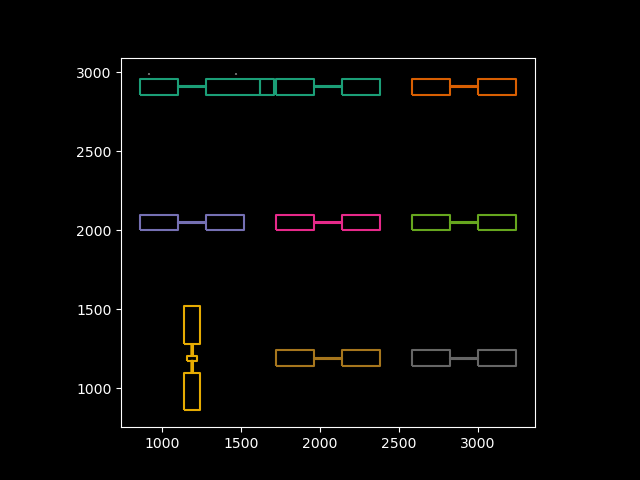

In [20]:
if global_align_on == 1:
    
    #Plot the final dxf file which was written to EBL
    df = gpd.read_file('{}_align.dxf'.format(os.path.splitext(inputFileName)[0]))
    ax = df.plot(column='Layer', cmap='Dark2')
    ax.set_facecolor((0, 0, 0))
    
    gobj_12 = BEAMER.import_dxf( {
    'LayerSet' : '*',
    'DXFUnits' : 'um',
    'DXFPolyMode' : 'ConvertToPolygon',
    'MaxErrorForConversion' : 0.001000,
    'SnappingRange' : 0.000500,
    'DXFDatabaseGrid' : 0.001000,
    'UseDXFInternalPrecision' : True,
    'ConvertDXFColorToDatatype' : False,
    'LoadTextElements' : False,
    'ConvertTextElementsToPolys' : False,
    'PreserveSingleLines' : False,
    'KeepElementOrder' : False,
    'ConvertedTextSize' : 1.000000,
    'PreserveSingleLines' : False,
    'FileName' : '{}_align.dxf'.format(os.path.splitext(inputFileName)[0]) } )
    
    fieldDoseTotal = {}
    fieldDoseMin = {}
    for n in matrix_indices:

        if num_obj_dic[n] > 0:
            dose_list = []
            for x in final_active_layers[n]:
                dose_list.append([x,dosefactor])

            layer_set = ''
            for x in final_active_layers[n]:
                if final_active_layers[n].index(x) == 0:
                    layer_set = layer_set + x
                else:
                    layer_set = layer_set + ',' + x

            fileExportName = '{}_{}'.format(n,baseExportName)

            gobj_22 = BEAMER.extract( gobj_12, {
                'ExtentMode' : 'Default',
                'ExtractMode' : 'EntireLayoutExtract',
                'CellName' : '',
                'LayerSet' : layer_set,
                'RegionLayer' : '',
                'RegionLayerBehavior' : 'Clip',
                'AllExceptForRegions' : False,
                'DoseClassificationShrink' : 0,
                'KeepRegionLayer' : False,
                'ExtractBoxes' : [] } )

            fieldDoseTotal.setdefault(n, []).append(BEAMER.get_area(gobj_2)*baseDoseTime*(dots/field)**2*10**(-6)*dosefactor)

            gobj_32 = BEAMER.heal( gobj_22, {
                'TargetLayer' : '1(0)',
                'SoftFrame' : 0.300000,
                'HierarchicalProcessing' : True,
                'SelectedLayerSet' : layer_set,
                'LayerAssignment' : 'PerLayer',
                'ProcessingMode' : 'Healing' } )
            
            if pec_on == 1:
                gobj_42 = BEAMER.pec( gobj_32, {
                    'UserdefinedDoseClassFile' : '**filename**', 
                    'MinFractureSizeMode' : 'Automatic', 
                    'BeamSize' : 0.010000, 
                    'DoseClassMode' : 'Accuracy', 
                    'MaxNumOfDoseClasses' : 256, 
                    'Accuracy' : 1.000000, 
                    'UserDefinedSeparationValue' : False, 
                    'SeparationValue' : 0.100000, 
                    'FractureGrid' : 0.010000, 
                    'MinFractureSize' : 0.100000, 
                    'MinFractureSizeShortRange' : 0.100000, 
                    'MinDoseFactor' : 0.100000, 
                    'MaxDoseFactor' : 10.000000, 
                    'LayerListForCorrection' : '*', 
                    'LayerListForFullCorrection' : layer_set, 
                    'LayerForFracture' : '*', 
                    'ContrastPartofLRPEC' : 100.000000, 
                    'PSFFileName' : '', 
                    'OverdoseFactor' : 1.000000, 
                    'PSFType' : 'Archive', 
                    'MidRangeActivationThreshold' : 2.000000, 
                    'SingleLineBeamWidth' : 0.000000, 
                    'IncludeSRCorrection' : False, 
                    'HierarchicShortRangePEC' : True, 
                    'HierarchicLongRangePEC' : False, 
                    'ConvergenceOutput' : False, 
                    'IncludeLateralDevelopment' : False, 
                    'LateralDevelopmentGrid' : 0.100000, 
                    'PSFArchiveIdentifierString' : psf_string, 
                    'CellsToKeep' : '', 
                    'Use2dLateralDevelopmentBias' : False } )
            else:
                gobj_42 = gobj_32


            gobj_52 = BEAMER.fda( gobj_42, {
                'AssignmentType' : 'Multiply',
                'AssignmentMode' : 'ByLayer',
                'LayerDoseList' : dose_list,
                'LayerDoseSigmaList' : [] } )

            fieldDoseMin.setdefault(n, []).append(BEAMER.get_min_dose(gobj_42)*baseDoseTime*dosefactor)

            if local_align_on == 1:
                if n in local_pts_dic.keys():
                    local_align_exist = 1
                    swtiched_local_pts = OrderPointsABCDElionix(local_pts_dic[n])
                    final_local_pts = [tuple(map(lambda y: y*10**(-3),x)) for x in swtiched_local_pts]
                else:
                    local_align_exist = 0
            else:
                local_align_exist = 0

            if np.logical_and(local_align_exist,local_align_on):
                local_align_flag = 'RL4'

                if EBLprinter == 5:
                    gobj_62 = BEAMER.export_con( gobj_52, { 
                         'FileName' : fileExportName, 
                         'ExtentMode' : 'Default', 
                         'LowerLeftX' : 0.000000, 
                         'LowerLeftY' : 0.000000, 
                         'UpperRightX' : 0.000000, 
                         'UpperRightY' : 0.000000, 
                         'FormatType' : 'SCON', 
                         'FieldSizeX' : format(field, '.5f'), 
                         'FieldSizeY' : format(field, '.5f'), 
                         'DotNumber' : dots, 
                         'MaximumFieldSize' : field, 
                         'BaseDoseTime' : format(baseDoseTime, '.5f'), 
                         'RectangleOrientation' : 'X_AND_Y', 
                         'PitchSize' : 1, 
                         'NumberGlobalMarks' : 0, 
                         'MarkA_X' : 0.000000, 'MarkA_Y' : 0.000000, 
                         'MarkB_X' : 0.000000, 'MarkB_Y' : 0.000000, 
                         'MarkC_X' : 0.000000, 'MarkC_Y' : 0.000000, 
                         'MarkD_X' : 0.000000, 'MarkD_Y' : 0.000000, 
                         'LocalMarkCommand' : local_align_flag, 
                         'LocalMarkPositionX1' : format(final_local_pts[0][0], '.5f'), 'LocalMarkPositionY1' : format(final_local_pts[0][1], '.5f'), 
                         'LocalMarkPositionX2' : format(final_local_pts[1][0], '.5f'), 'LocalMarkPositionY2' : format(final_local_pts[1][1], '.5f'), 
                         'LocalMarkPositionX3' : format(final_local_pts[2][0], '.5f'), 'LocalMarkPositionY3' : format(final_local_pts[2][1], '.5f'), 
                         'LocalMarkPositionX4' : format(final_local_pts[3][0], '.5f'), 'LocalMarkPositionY4' : format(final_local_pts[3][1], '.5f'), 
                         'RegionLayer' : '', 
                         'FieldTraversalType' : 'Floating', 
                         'FixedFieldTraversal' : 'MeanderX', 
                         'FractureMode' : 'Curved', 
                         'CurveTolerance' : 1.000000, 
                         'ShotPitchAlignment' : 'NONE', 
                         'DoseTimeInterpolation' : False, 
                         'ReplaceFiles' : False, 
                         'GenerateFolder' : False, 
                         'GenerateCCCFiles' : True, 
                         'GenerateCPGData' : True, 
                         'GenerateParallelograms' : False, 
                         'KeepLayoutPosition' : True, 
                         'CenterFieldFrames' : False, 
                         'AdaptDoseToShotPitch' : 'CONSTANT', 
                         'AreaSelection' : 'SelectedThenRemainder', 
                         'FeatureOrderingType' : 'NoCompaction', 
                         'CompRegSize' : 500, 
                         'RegTraversal' : 'MeanderX', 
                         'SortedOrderLayer' : '*', 
                         'DoseMapping' : 'DoseToTime', 
                         'FieldOverlapX' : 0.000000, 
                         'FieldOverlapY' : 0.000000, 
                         'OverlapMethod' : 'Share between Fields', 
                         'InterleavingSize' : 0.000000, 
                         'InterlockLayer' : '*', 
                         'MultipassMode' : 'Single Pass', 
                         'MultipassFieldArrangement' : 'Shortest Path', 
                         'MainfieldOffsetX' : 0.500000, 
                         'MainfieldOffsetY' : 0.500000, 
                         'SubfieldOffsetX' : 0.000000, 
                         'SubfieldOffsetY' : 0.000000, 
                         'MultipassLayer' : '*', 
                         'UserDosePass' : []} )
                elif EBLprinter == 6:
                    gobj_62 = BEAMER.export_car( gobj_52, { 
                        'FileName' : fileExportName, 
                        'ExtentMode' : 'Minimum', 
                        'LowerLeftX' : 0.000000, 
                        'LowerLeftY' : 0.000000, 
                        'UpperRightX' : 0.000000, 
                        'UpperRightY' : 0.000000, 
                        'ReplaceFiles' : False, 
                        'GenerateFolder' : True, 
                        'FormatType' : 'Fixed subfield', 
                        'MaximumFieldSize' : field, 
                        'SubfieldSize' : 10.0, 
                        'FieldSizeX' : format(field, '.5f'), 
                        'FieldSizeY' : format(field, '.5f'),
                        'PitchSize' : 1, 
                        'AdaptDoseToShotPitch' : 'CONSTANT', 
                        'RectangleOrientation' : 'X_AND_Y', 
                        'GenerateCPGData' : True, 
                        'GenerateParallelograms' : False, 
                        'FieldTraversalType' : field_option, 
                        'KeepLayoutPosition' : True, 
                        'FractureMode' : 'Curved', 
                        'CurveTolerance' : 1.000000, 
                        'SymmetricFracturing' : False, 
                        'ShotPitchAlignment' : 'NONE', 
                        'FeatureOrderingType' : 'FixedSubfields', 
                        'SortedOrderLayer' : '*', 
                        'CompRegSize' : field, 
                        'RegTraversal' : 'MeanderX', 
                        'FixedSubfieldOrigin' : 'CenterToCenter', 
                        'LocalMarkCommand' : local_align_flag, 
                        'LocalMarkPositionX1' : format(final_local_pts[0][0], '.5f'), 'LocalMarkPositionY1' : format(final_local_pts[0][1], '.5f'), 
                        'LocalMarkPositionX2' : format(final_local_pts[1][0], '.5f'), 'LocalMarkPositionY2' : format(final_local_pts[1][1], '.5f'), 
                        'LocalMarkPositionX3' : format(final_local_pts[2][0], '.5f'), 'LocalMarkPositionY3' : format(final_local_pts[2][1], '.5f'), 
                        'LocalMarkPositionX4' : format(final_local_pts[3][0], '.5f'), 'LocalMarkPositionY4' : format(final_local_pts[3][1], '.5f'), 
                        'FieldAlignmentCommand' : 'None', 
                        'FieldMarkPosition1X' : 0.000000, 
                        'FieldMarkPositionY' : 0.000000, 
                        'FieldMarkPosition2X' : 0.000000, 
                        'FieldMarkPosition2Y' : 0.000000, 
                        'FinePitch_X' : '', 
                        'FinePitch_Y' : '', 
                        'Moving_Z' : '', 
                        'MovingXY_X' : '', 
                        'MovingXY_Y' : '', 
                        'FieldOverlapX' : 0.000000, 
                        'FieldOverlapY' : 0.000000, 
                        'MultipassMode' : 'Single Pass' } )
                else:
                        print("That EBL instrument is not yet implemented")

            else:
                local_align_flag = 'None'
                
                if EBLprinter == 5:
                    gobj_62 = BEAMER.export_con( gobj_52, { 
                         'FileName' : fileExportName, 
                         'ExtentMode' : 'Default', 
                         'LowerLeftX' : 0.000000, 
                         'LowerLeftY' : 0.000000, 
                         'UpperRightX' : 0.000000, 
                         'UpperRightY' : 0.000000, 
                         'FormatType' : 'SCON', 
                         'FieldSizeX' : format(field, '.5f'), 
                         'FieldSizeY' : format(field, '.5f'), 
                         'DotNumber' : dots, 
                         'MaximumFieldSize' : field, 
                         'BaseDoseTime' : format(baseDoseTime, '.5f'), 
                         'RectangleOrientation' : 'X_AND_Y', 
                         'PitchSize' : 1, 
                         'NumberGlobalMarks' : 0, 
                         'MarkA_X' : 0.000000, 'MarkA_Y' : 0.000000, 
                         'MarkB_X' : 0.000000, 'MarkB_Y' : 0.000000, 
                         'MarkC_X' : 0.000000, 'MarkC_Y' : 0.000000, 
                         'MarkD_X' : 0.000000, 'MarkD_Y' : 0.000000, 
                         'LocalMarkCommand' : local_align_flag, 
                         'LocalMarkPositionX1' : 0.000000, 'LocalMarkPositionY1' : 0.000000, 
                         'LocalMarkPositionX2' : 0.000000, 'LocalMarkPositionY2' : 0.000000, 
                         'LocalMarkPositionX3' : 0.000000, 'LocalMarkPositionY3' : 0.000000, 
                         'LocalMarkPositionX4' : 0.000000, 'LocalMarkPositionY4' : 0.000000, 
                         'RegionLayer' : '', 
                         'FieldTraversalType' : field_option, 
                         'FixedFieldTraversal' : 'MeanderX', 
                         'FractureMode' : 'Curved', 
                         'CurveTolerance' : 1.000000, 
                         'ShotPitchAlignment' : 'NONE', 
                         'DoseTimeInterpolation' : False, 
                         'ReplaceFiles' : False, 
                         'GenerateFolder' : False, 
                         'GenerateCCCFiles' : True, 
                         'GenerateCPGData' : True, 
                         'GenerateParallelograms' : False, 
                         'KeepLayoutPosition' : True, 
                         'CenterFieldFrames' : False, 
                         'AdaptDoseToShotPitch' : 'CONSTANT', 
                         'AreaSelection' : 'SelectedThenRemainder', 
                         'FeatureOrderingType' : 'NoCompaction', 
                         'CompRegSize' : 500, 
                         'RegTraversal' : 'MeanderX', 
                         'SortedOrderLayer' : '*', 
                         'DoseMapping' : 'DoseToTime', 
                         'FieldOverlapX' : 0.000000, 
                         'FieldOverlapY' : 0.000000, 
                         'OverlapMethod' : 'Share between Fields', 
                         'InterleavingSize' : 0.000000, 
                         'InterlockLayer' : '*', 
                         'MultipassMode' : 'Single Pass', 
                         'MultipassFieldArrangement' : 'Shortest Path', 
                         'MainfieldOffsetX' : 0.500000, 
                         'MainfieldOffsetY' : 0.500000, 
                         'SubfieldOffsetX' : 0.000000, 
                         'SubfieldOffsetY' : 0.000000, 
                         'MultipassLayer' : '*', 
                         'UserDosePass' : []} )
                elif EBLprinter == 6:
                    gobj_62 = BEAMER.export_car( gobj_52, { 
                        'FileName' : fileExportName.split('.')[0] + '.car', 
                        'ExtentMode' : 'Minimum', 
                        'LowerLeftX' : 0.000000, 
                        'LowerLeftY' : 0.000000, 
                        'UpperRightX' : 0.000000, 
                        'UpperRightY' : 0.000000, 
                        'ReplaceFiles' : False, 
                        'GenerateFolder' : True, 
                        'FormatType' : 'Fixed subfield', 
                        'MaximumFieldSize' : field, 
                        'SubfieldSize' : 10.0, 
                        'FieldSizeX' : format(field, '.5f'), 
                        'FieldSizeY' : format(field, '.5f'),
                        'PitchSize' : 1, 
                        'AdaptDoseToShotPitch' : 'CONSTANT', 
                        'RectangleOrientation' : 'X_AND_Y', 
                        'GenerateCPGData' : True, 
                        'GenerateParallelograms' : False, 
                        'FieldTraversalType' : field_option, 
                        'KeepLayoutPosition' : True, 
                        'FractureMode' : 'Curved', 
                        'CurveTolerance' : 1.000000, 
                        'SymmetricFracturing' : False, 
                        'ShotPitchAlignment' : 'NONE', 
                        'FeatureOrderingType' : 'FixedSubfields', 
                        'SortedOrderLayer' : '*', 
                        'CompRegSize' : field, 
                        'RegTraversal' : 'MeanderX', 
                        'FixedSubfieldOrigin' : 'CenterToCenter', 
                        'LocalMarkCommand' : local_align_flag, 
                        'LocalMarkPositionX1' : 0.000000, 'LocalMarkPositionY1' : 0.000000, 
                        'LocalMarkPositionX2' : 0.000000, 'LocalMarkPositionY2' : 0.000000, 
                        'LocalMarkPositionX3' : 0.000000, 'LocalMarkPositionY3' : 0.000000, 
                        'LocalMarkPositionX4' : 0.000000, 'LocalMarkPositionY4' : 0.000000, 
                        'FieldAlignmentCommand' : 'None', 
                        'FieldMarkPosition1X' : 0.000000, 
                        'FieldMarkPositionY' : 0.000000, 
                        'FieldMarkPosition2X' : 0.000000, 
                        'FieldMarkPosition2Y' : 0.000000, 
                        'FinePitch_X' : '', 
                        'FinePitch_Y' : '', 
                        'Moving_Z' : '', 
                        'MovingXY_X' : '', 
                        'MovingXY_Y' : '', 
                        'FieldOverlapX' : 0.000000, 
                        'FieldOverlapY' : 0.000000, 
                        'MultipassMode' : 'Single Pass' } )
                else:
                        print("That EBL instrument is not yet implemented")

In [21]:
if type(fieldDoseTotal) == float:
    doseTotalTime = fieldDoseTotal
else:
    doseTotalTime = sum([x[0] for x in fieldDoseTotal.values()])
if type(fieldDoseTotal) == float:
    doseMinTime = fieldDoseMin
else:
    doseMinTime = min([x[0] for x in fieldDoseMin.values()])

### Logging

In [22]:
with open('pythonLog.txt','w') as f:
    if doseMinTime < 0.01:
        print("Dose Time too Short! Decrease the current. Change the number of passes. Think!", file=f)
    print("Base Dose = {} us/dot".format(baseDoseTime), file=f)
    print("Total Dose Time = {} hh:mm:ss".format(str(datetime.timedelta(seconds=int(doseTotalTime)))), file=f)
    if open_poly_flag > 0:
        print('You have open polylines. Go use linkCAD', file=f)
if doseMinTime < 0.01:
    print("Dose Time too Short! Decrease the current. Change the number of passes. Think!")
print("Base Dose = {} us/dot".format(baseDoseTime))
print("Total Dose Time = {} hh:mm:ss".format(str(datetime.timedelta(seconds=int(doseTotalTime)))))
if open_poly_flag > 0:
    print('You have open polylines. Go use linkCAD')

Base Dose = 0.041666666666666664 us/dot
Total Dose Time = 0:21:58 hh:mm:ss
